# Integration
## in practice and theory
Let's take a look at some of the tools that SciPy provides for numerical integration, as well as some implementation of the basic algorithms.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad, dblquad, odeint
from time import time

import warnings
warnings.filterwarnings('ignore')

### Single variable integration
The basic 1D integration tool in `scipy.integrate` is `quad`.  Let's compute a very simple integral, one that we can compute in closed form:
$$\int_0^{\pi/2} \cos(x) = 1.$$
The basic syntax is `quad(f,a,b)`, where `f` should be a real valued function. For this one, we can just use `np.cos`.

In [2]:
quad(np.cos, 0,np.pi/2)

(0.9999999999999999, 1.1102230246251564e-14)

The result is a 2-tuple: `(result,error)`.

Let's compare it to simpler left, trapezoidal, and Simpson sums.

In [3]:
def left_sum(f,a,b,n):
    xs = np.linspace(a,b,n+1)
    ys = f(xs)
    return sum([ys[i] for i in range(n)])*(b-a)/(n)
left_sum(np.cos, 0, np.pi/2, 100)

1.0078334198735821

In [4]:
def trapezoidal_sum(f,a,b,n):
    xs = np.linspace(a,b,n+1)
    ys = f(xs)
    return sum([(ys[i+1]+ys[i]) for i in range(n)])*(b-a)/(2*n)
trapezoidal_sum(np.cos, 0, np.pi/2, 100)

0.99997943823960711

In [5]:
def simps(f,a,b,n):
    xs = np.linspace(a,b,n+1)
    ys = f(xs)
    return sum([(ys[i]+4*ys[i+1]+ys[i+2]) for i in range(0,n,2)])*(b-a)/(3*n)
simps(np.cos, 0, np.pi/2, 100)

1.0000000003382359

Not bad! Note how each approximation is an improvement.  Let's try a harder example - the ever popular error function:
$$\int_0^2 e^{-x^2} dx \approx ?$$
Note that we often use a `lambda` function when doing an isolated itegral computation.

In [6]:
quad_answer, quad_error = quad(lambda x: np.exp(-x**2), 0,2)
quad_answer, quad_error

(0.8820813907624215, 9.793070696178202e-15)

In [7]:
trapezoidal_sum(lambda x: np.exp(-x**2), 0, 2, 100)

0.88207894884004256

And here is a direct transcription of Gilvis's Discourse answer:

In [8]:
gilvis_answer = sum(\
    [(np.exp(-(2*i/130)**2)+np.exp(-(2*(i-1)/130)**2))/130 \
        for i in range(1,131)])
gilvis_answer

0.88207994579860516

This is supposed to be within $0.0001=10^{-4}$ of the actual result.

In [9]:
quad_answer - gilvis_answer

1.4449638163771539e-06

### Plotting and `odeint`
Often, we like to plot things. Here's a cool example that requires quite a few points, due to the oscilation.

0.1467888355255127

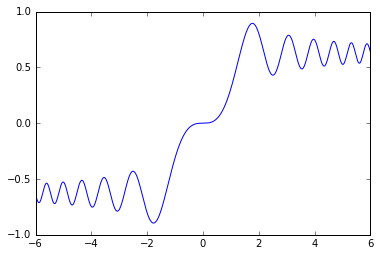

In [10]:
def f(x): return quad(lambda t: np.sin(t**2), 0,x)[0]
xs = np.linspace(-6,6,1001)
t = time()
ys = [f(x) for x in xs]
t = time()-t
plt.plot(xs,ys)
t

Note that we timed the computation as well: less than two-tenths of a second, which doesn't seem *so* bad. Often, we can be more efficient by expressing the integral as a differential equation:
$$y(x) = \int_0^x f(t) dt \: \Longleftrightarrow \: y'(x) = f(x) \text{ and } y(0) = 0.$$
The problem with the code above is that it computes
$$\int_0^x \sin(t^2)dt$$
for *every* $x$ in the domain of interest. A numerical ODE solver builds up the solution as we go along, so it can be much more efficient. We'll talk more about how this works later, but the differential equation with boundary condtion can be stated as 
$$y'(x) = \sin(x^2) \text{ and } y(0) = 0.$$

0.0023221969604492188

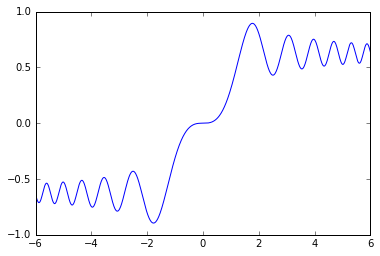

In [11]:
t = time()
ys = odeint(lambda y,x: np.sin(x**2), 0, xs)
ys = ys-ys[int(len(ys)/2)] # adjust for the bc
t = time()-t
plt.plot(xs,ys)
t

Well, that is a lot faster!

### A double integral
Here's a classic problem: Determine 
$$\iint_D x^2 dA,$$
where $A$ is the shaded area between the following two curves.

(-1.5, 5)

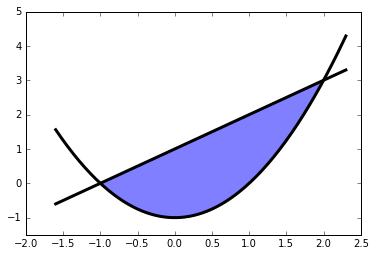

In [12]:
def f1(x): return x**2 - 1
def f2(x): return x+1
xs = np.linspace(-1,2,150)
ys1 = f1(xs)
ys2 = f2(xs)
plt.fill_between(xs,ys1,ys2, alpha=0.5)
xs = np.linspace(-1.6,2.3,150)
ys1 = f1(xs)
ys2 = f2(xs)
plt.plot(xs,ys1, 'k', linewidth=3)
plt.plot(xs,ys2, 'k', linewidth=3)
ax = plt.gca()
ax.set_ylim(-1.5,5)

In calculus speak, the area is
$$\int_{-1}^2\int_{x^2-1}^{x+1} x^2 dx.$$
Here's how to compute these in SciPy. Note that the bounds on $y$ are *always* functions, though they can be constant functions.

I don't know why $x$ and $y$ are backward from the usual.

In [13]:
dblquad(lambda y,x: x**2, -1,2, f1,f2)

(3.1500000000000004, 3.497202527569244e-14)

### The area of the Mandelbrot set
Here's a fun application. Let's define a function $\chi_M$ on the complex plane by
$$\chi_M(z) = \left\{
\begin{array}{ll}
    1 & \text{if } z \text{ is in the Mandelbrot set} \\
    0 & \text{if } z \text{ is not in the Mandelbrot set}.
\end{array}\right.$$
Then,

$$\iint_{\mathbb C} \chi_M(x+iy) \, dA$$
should be the area of the Mandelbrot set. There's really noting special here about the Mandelbrot set just yet, but it seems cool.

All we need is $\chi_M$! Note that a complex number $c$ is in the Mandelbrot set by definition if the orbit of the critical point zero under iteration of
$$f_c(z)=z^2+c$$
remains bounded. We can use this to write an `in_mandel` function as follows:

In [14]:
from numba import jit

@jit
def in_mandel(y,x, max_iters=100):
    c = complex(x,y)+0.0j
    z = c
    cnt = 0
    while(z.real*z.real + z.imag*z.imag <= 4 and cnt < max_iters):
        z = z*z+c
        cnt = cnt+1
    if cnt<max_iters:
        return 0
    else:
        return 1

In [15]:
dblquad(in_mandel, -2,0.6, lambda x: -1.3, lambda x: 1.3)

(1.5393369778214687, 0.004434045780471685)

Note that Wikipedia reports the are to be $1.5065918849 \pm 0.0000000028$ so, the error estimate isn't so good. We can improve things a bit by increasing the additional `max_iters` argument of `in_mandel` by using the `args` argument of `dblquad`.

In [16]:
dblquad(in_mandel, -2,0.6, lambda x: -1.3, lambda x: 1.3, args=(1000,))

(1.504980396290177, 0.005573739233831088)

Not bad!